In [1]:
import os
import csv
import copy
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
# load eeci_colors from csv
colors_file = 'eeci_colors.csv'
with open (colors_file, 'r') as f:
    reader = csv.reader(f)
    eeci_colors = reader.__next__()

In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=eeci_colors)

In [4]:
UCam_ids = [0,3,9,11,12,15,16,25,26,32,38,44,45,48,49]

results_file = os.path.join('..','results', 'prediction_tests_generalisation.csv')
gen_results = pd.read_csv(results_file)
rmse_results = gen_results[gen_results['Metric']=='gmnRMSE']

correlations_dir = os.path.join('..','data','analysis','correlations')
wass_corrs = pd.read_csv(os.path.join(correlations_dir,'wasserstein.csv'),index_col=0)
mae_corrs = pd.read_csv(os.path.join(correlations_dir,'mae.csv'),index_col=0) # NOTE: old file
rmse_corrs = pd.read_csv(os.path.join(correlations_dir,'rmse.csv'),index_col=0) # NOTE: old file

models = ['linear', 'conv', 'resmlp', 'TFT', 'NHiTS']
model_names = ['Linear', 'Conv', 'ResMLP', 'TFT', 'NHiTS']
metric_scores = {}
for model in models:
    metric_scores[model] = [[float(rmse_results[(rmse_results['Model Name'] == model) & (rmse_results['Train Building'] == t_id)]['L%s'%p_id]) for p_id in UCam_ids] for t_id in UCam_ids]

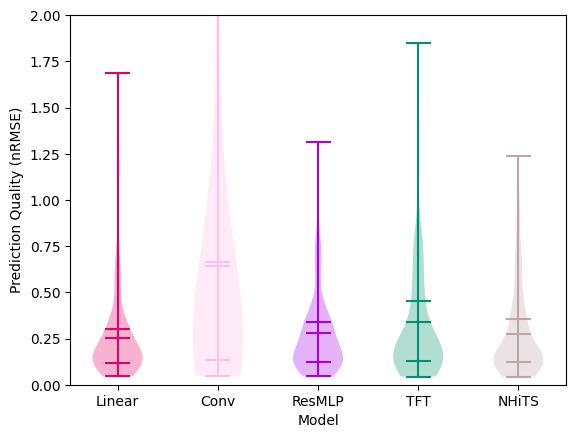

In [5]:
# Plot distribution of generalisation scores
fig,ax = plt.subplots()
for i,model in enumerate(models):
    ax.violinplot(np.array(metric_scores[model]).flatten(),[i],showmeans=True,showmedians=False,quantiles=[[0.25,0.75]],points=500)
ax.set_ylim(0,2)
ax.set_ylabel('Prediction Quality (nRMSE)')
ax.set_xlabel('Model')
ax.set_xticks(list(range(len(models))))
ax.set_xticklabels(model_names)
plt.show()

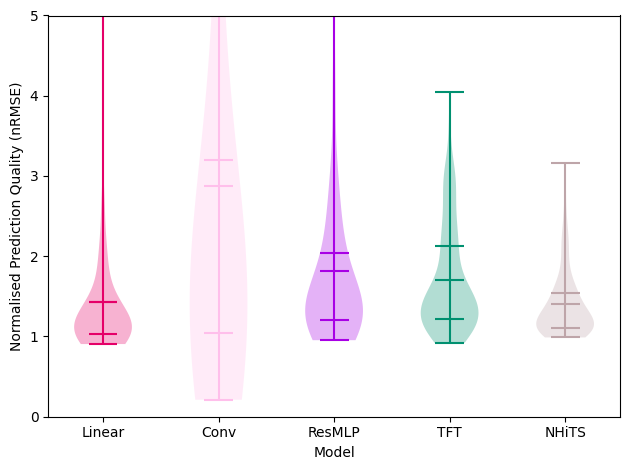

In [6]:
# Plot distribution of generalisation scores
fig,ax = plt.subplots()
for i,model in enumerate(models):
    ax.violinplot((np.array(metric_scores[model])/np.diagonal(metric_scores[model])).flatten(),[i],showmeans=True,showmedians=False,quantiles=[[0.25,0.75]],points=500)
ax.set_ylim(0,5)
ax.set_ylabel('Normalised Prediction Quality (nRMSE)')
ax.set_xlabel('Model')
ax.set_xticks(list(range(len(models))))
ax.set_xticklabels(model_names)
plt.tight_layout()
fig.savefig('generalisation_violin.pdf')
plt.show()

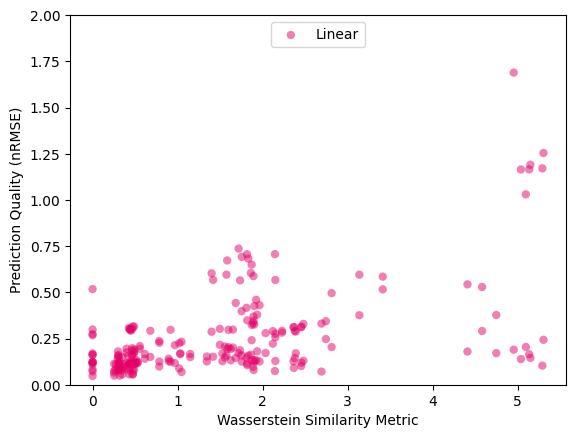

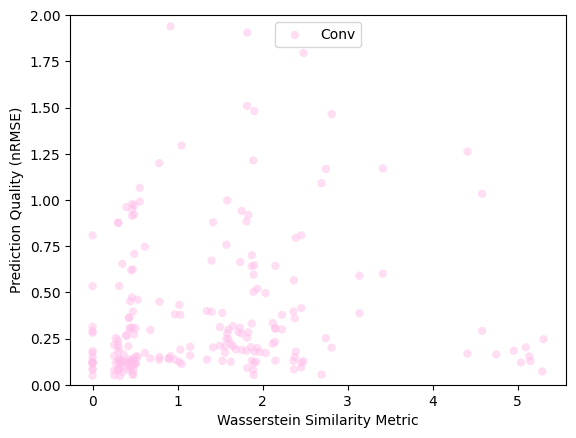

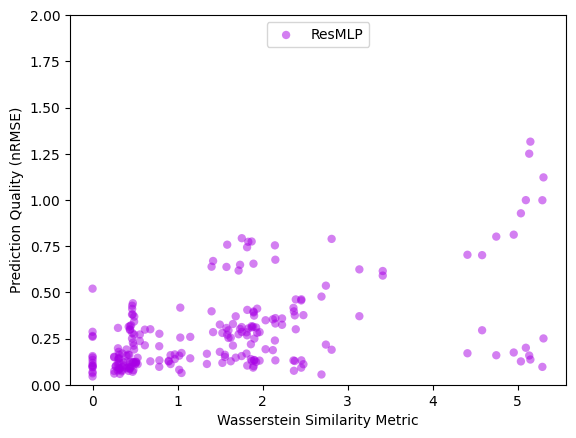

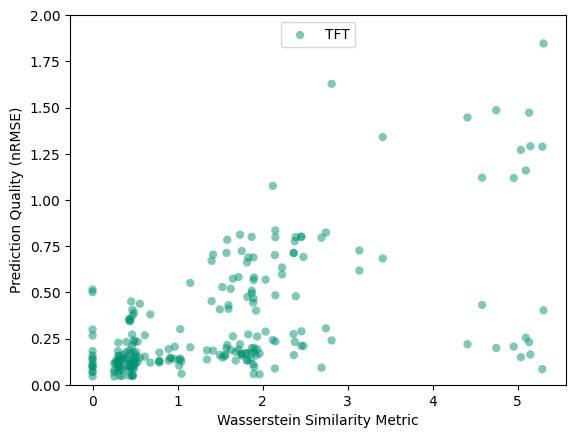

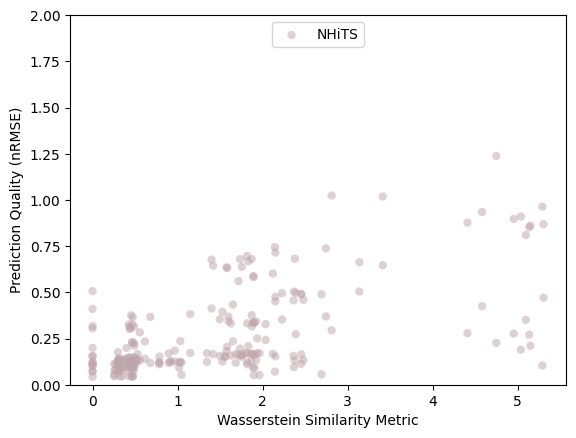

In [7]:
# Plot correlation between generalisation scores and wasserstein distance
for i,model in enumerate(models):
    fig,ax = plt.subplots()
    ax.scatter(wass_corrs.to_numpy().flatten(),np.array(metric_scores[model]).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
    ax.set_ylim(0,2)
    ax.set_ylabel('Prediction Quality (nRMSE)')
    ax.set_xlabel('Wasserstein Similarity Metric')
    plt.legend(fancybox=True, loc='upper center')
    plt.show()

In [8]:
# Do numerical analysis on generalisation performance results for Linear model, selected using Wasserstein metric
model = 'linear'

wss = wass_corrs.to_numpy().flatten()
ngpp = (np.array(metric_scores[model])/np.diagonal(metric_scores[model])).flatten()

naive_gen_scores = ngpp[np.where(wss != 0.0)]
naive_gen_mean_score = np.mean(naive_gen_scores)
ws_cutoff_gen_scores = ngpp[np.where((wss != 0.0) & (wss < 1))]
ws_cutoff_gen_mean_score = np.mean(ws_cutoff_gen_scores)

print(naive_gen_mean_score, min(naive_gen_scores), max(naive_gen_scores))
print(ws_cutoff_gen_mean_score, min(ws_cutoff_gen_scores), max(ws_cutoff_gen_scores))

# For each building, select the building with the lowest Wasserstein score for model reuse
best_sim_scores = []
wass_corrs_array = copy.deepcopy(wass_corrs.to_numpy())
ngpp_array = (np.array(metric_scores[model])/np.diagonal(metric_scores[model]))
wass_corrs_array[wass_corrs_array == 0.0] = 1000 # Set 0.0 values to a high value to avoid selecting them
for i in range(len(UCam_ids)):
    best_building_index = np.argmin(wass_corrs_array[i])
    best_sim_scores.append(ngpp_array[i][best_building_index])

print(best_sim_scores)
print(np.mean(best_sim_scores), min(best_sim_scores), max(best_sim_scores))

1.4536917826368272 0.9053854353687986 6.306788437005371
1.1830006241304742 0.9053854353687986 3.413401382618478
[1.0365497076691383, 0.9268795359634657, 1.5263002117768731, 1.0619361582633988, 0.9770247844584862, 1.2447060513029253, 1.0913358010012708, 1.0608525403342555, 0.9213758606440411, 1.4140926956973578, 1.0287979706003918, 0.9314336278948014, 1.3825384958479423, 1.0918861141614586, 0.9599428177113306]
1.1103768248884758 0.9213758606440411 1.5263002117768731


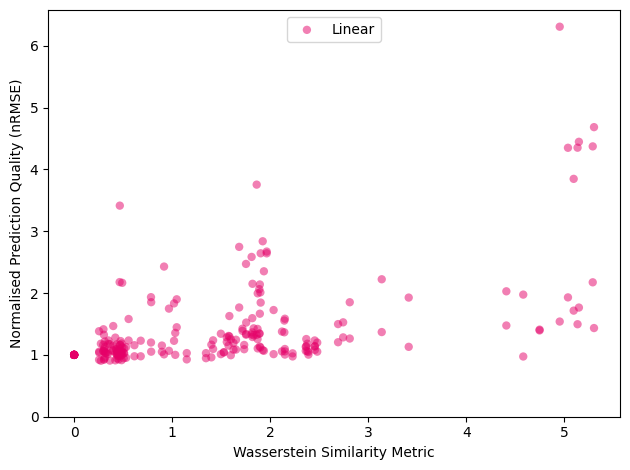

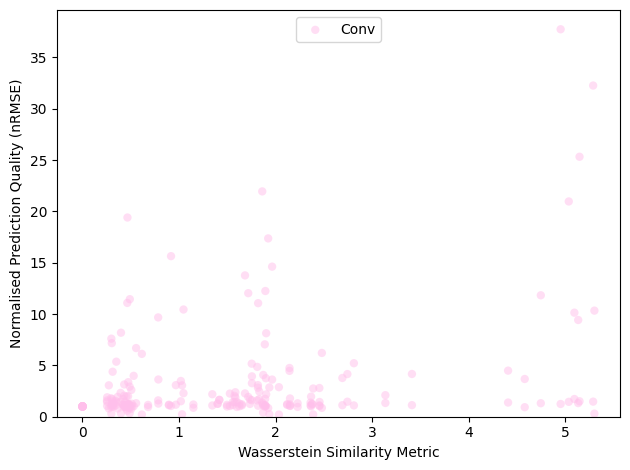

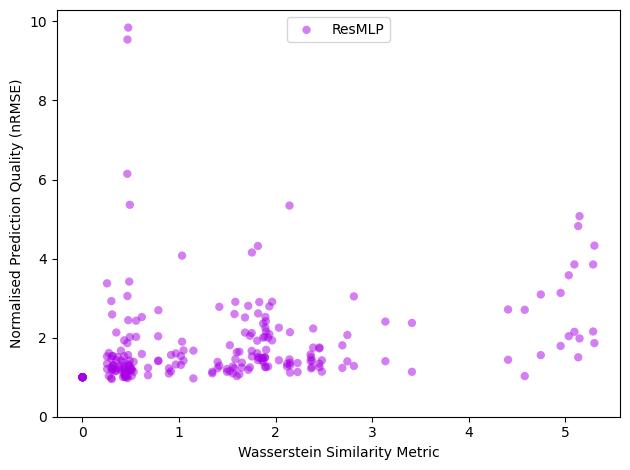

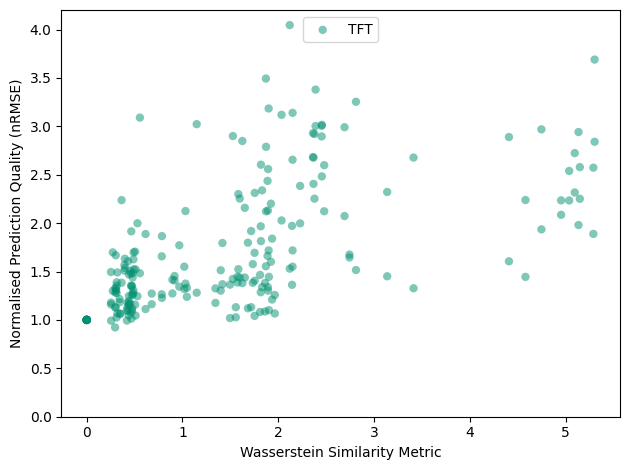

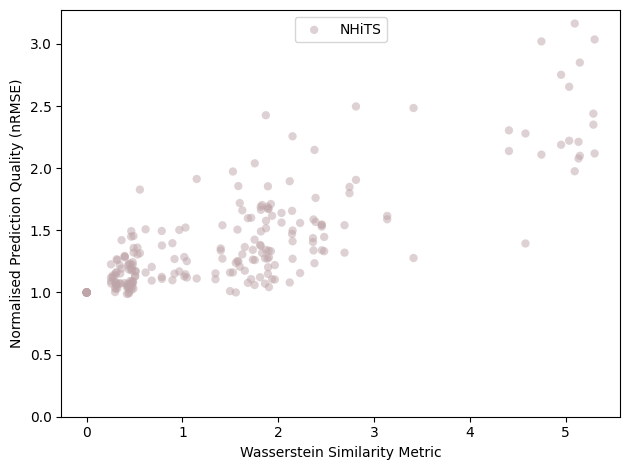

In [9]:
# Plot correlation between normalised generalisation scores and wasserstein distance
for i,model in enumerate(models):
    fig,ax = plt.subplots()
    ax.scatter(wass_corrs.to_numpy().flatten(),(np.array(metric_scores[model])/np.diagonal(metric_scores[model])).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
    ax.set_ylim(0)
    ax.set_ylabel('Normalised Prediction Quality (nRMSE)')
    ax.set_xlabel('Wasserstein Similarity Metric')
    plt.legend(fancybox=True, loc='upper center')
    plt.tight_layout()
    if model == 'linear':
        fig.savefig('generalisation_linear_similarity_corr.pdf')
    plt.show()

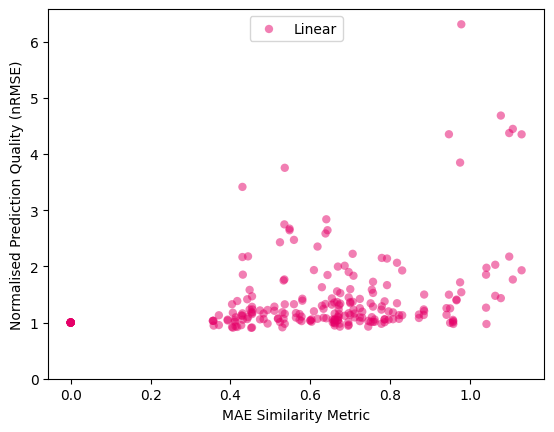

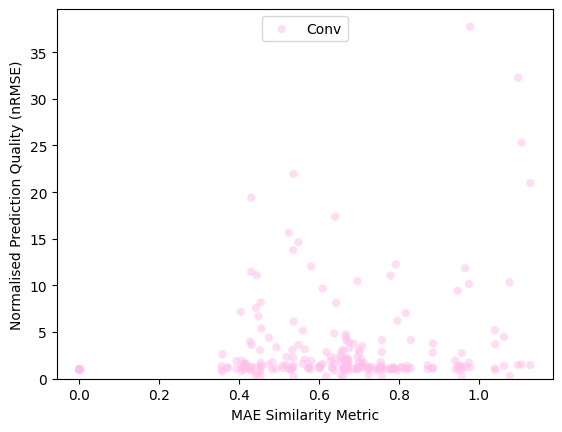

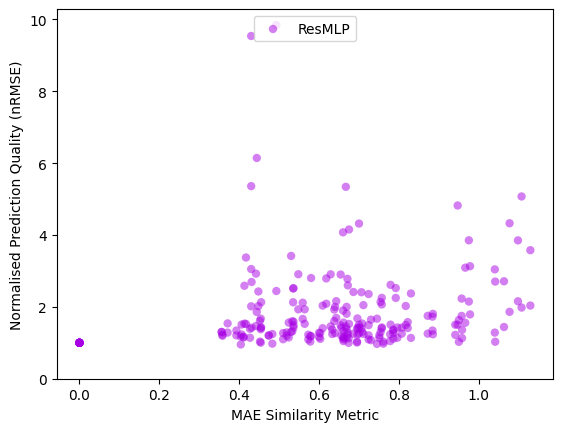

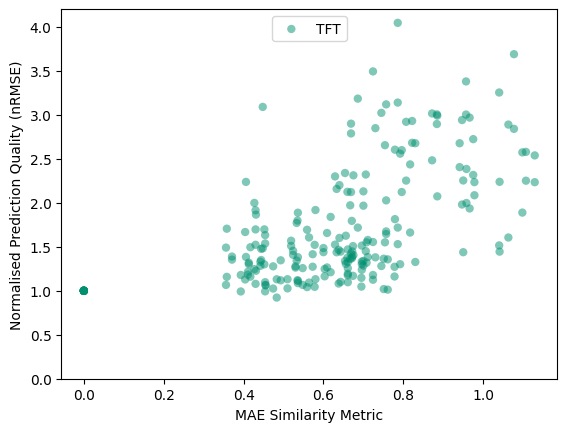

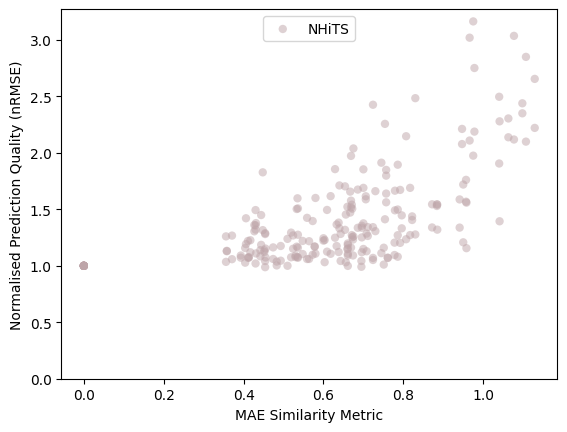

In [10]:
# Plot correlation between normalised generalisation scores and mae
for i,model in enumerate(models):
    fig,ax = plt.subplots()
    ax.scatter(mae_corrs.to_numpy().flatten(),np.array(metric_scores[model])/np.diagonal(metric_scores[model]).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
    ax.set_ylim(0)
    ax.set_ylabel('Normalised Prediction Quality (nRMSE)')
    ax.set_xlabel('MAE Similarity Metric')
    plt.legend(fancybox=True, loc='upper center')
    plt.show()

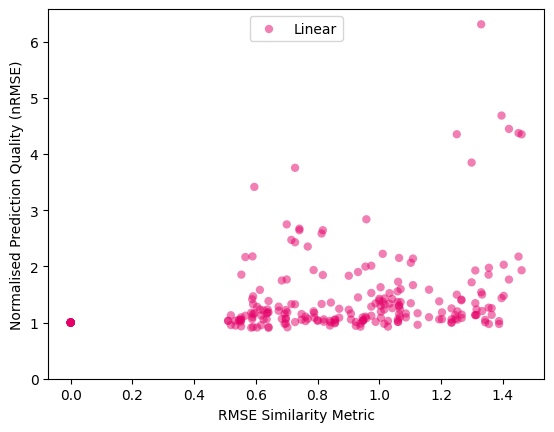

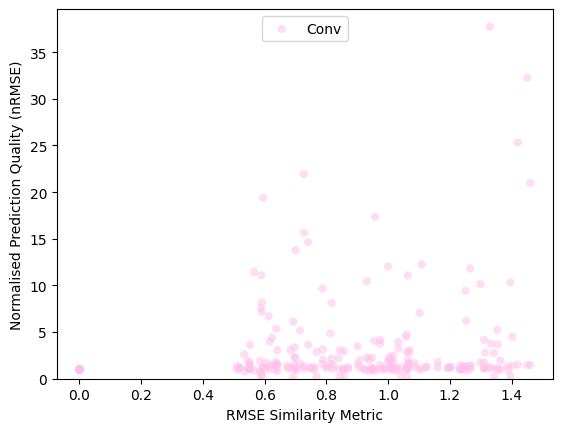

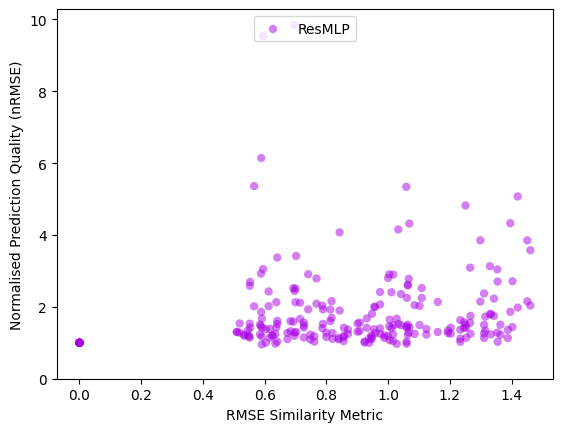

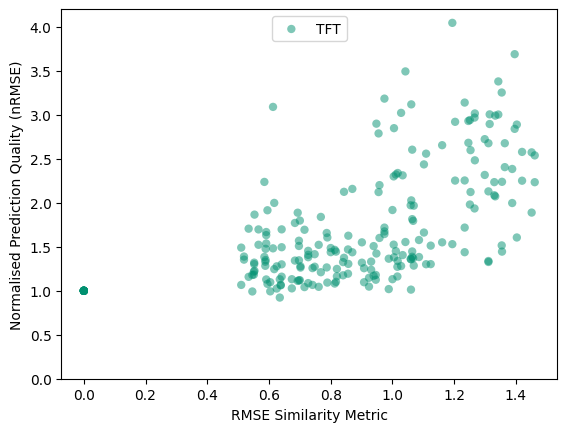

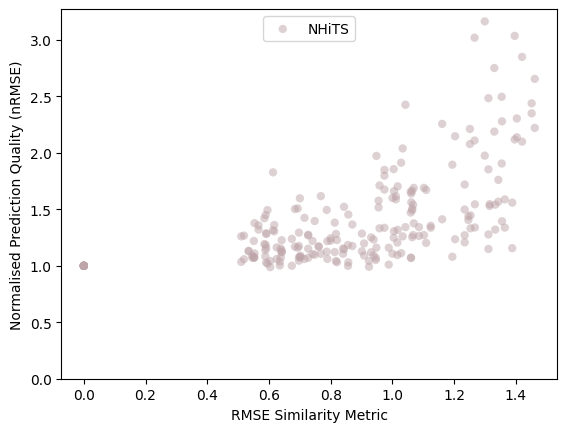

In [11]:
# Plot correlation between normalised generalisation scores and rmse
for i,model in enumerate(models):
    fig,ax = plt.subplots()
    ax.scatter(rmse_corrs.to_numpy().flatten(),np.array(metric_scores[model])/np.diagonal(metric_scores[model]).flatten(),label=model_names[i],color=eeci_colors[i],alpha=0.5,edgecolors='none')
    ax.set_ylim(0) # conv results go up to 9
    ax.set_ylabel('Normalised Prediction Quality (nRMSE)')
    ax.set_xlabel('RMSE Similarity Metric')
    plt.legend(fancybox=True, loc='upper center')
    plt.show()